In [24]:
import pandas as pd
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from tqdm import tqdm

df = pd.read_csv('paligemma_cleaned_predictions.csv')

smoother = SmoothingFunction().method4

def compute_bleu_score(references, hypothesis):
    references_tok = [ref.split() for ref in references]
    hypothesis_tok = hypothesis.split()
    return sentence_bleu(references_tok, hypothesis_tok, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoother)

def compute_meteor_score_nltk(references, hypothesis):
    references_tok = [ref.split() for ref in references]
    hypothesis_tok = hypothesis.split()
    return min(1.0, meteor_score(references_tok, hypothesis_tok))

bleu_scores = []
meteor_scores = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Evaluating Predictions"):
    references = [str(row[f'caption_{i}']).lower() for i in range(1, 6)]
    hypothesis = str(row['predicted_caption']).lower()

    bleu = compute_bleu_score(references, hypothesis)
    meteor = compute_meteor_score_nltk(references, hypothesis)

    bleu_scores.append(bleu)
    meteor_scores.append(meteor)

df['bleu_pred'] = bleu_scores
df['meteor_pred'] = meteor_scores

df.to_csv('paligemma_with_bleu_meteor_scores.csv', index=False)

print(f"\nOverall BLEU-4 Score: {np.mean(bleu_scores):.4f}")
print(f"Overall METEOR Score: {np.mean(meteor_scores):.4f}")


Evaluating Predictions: 100%|██████████| 4454/4454 [00:08<00:00, 516.55it/s]


Overall BLEU-4 Score: 0.0242
Overall METEOR Score: 0.0764



Showing first 10 examples with predicted captions and CLIP scores:


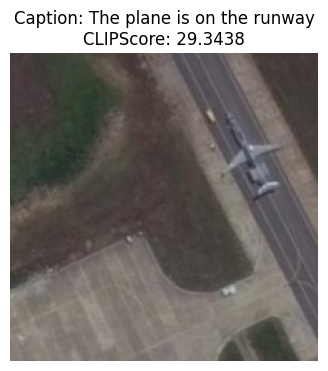

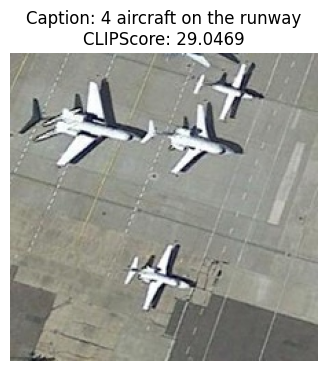

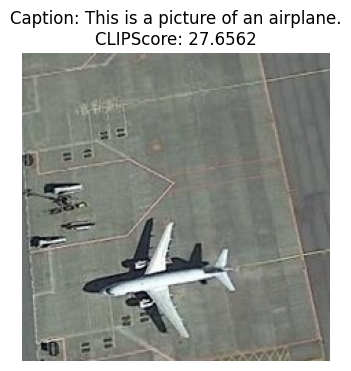

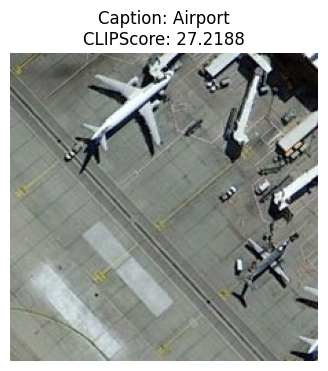

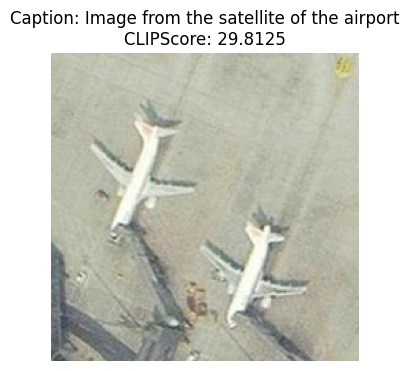

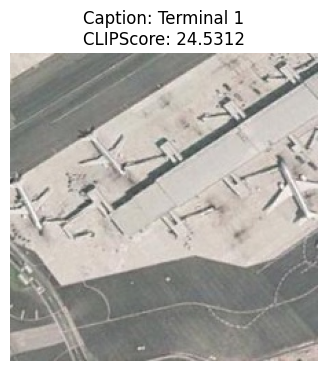

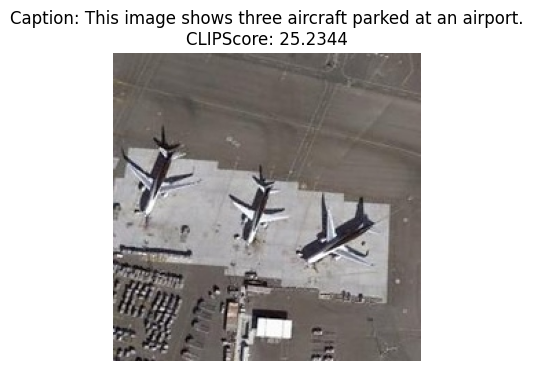

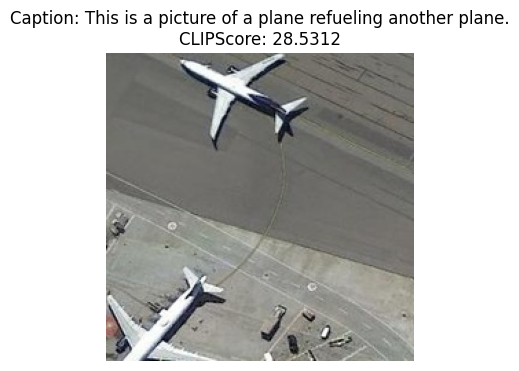

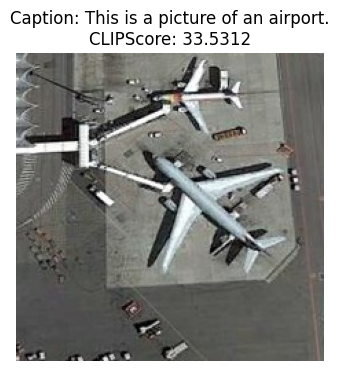

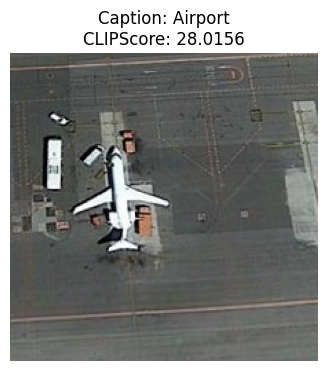

Computing CLIPScore: 100%|██████████| 4454/4454 [05:24<00:00, 13.74it/s]



Overall CLIPScore across all predictions: 29.3079
Min score: 13.6875, Max score: 39.9375
Overall Normalized CLIPScore: 0.5951

Normalized CLIPScores for the first 10 images:
Image 1: Normalized CLIPScore = 0.5964
Image 2: Normalized CLIPScore = 0.5851
Image 3: Normalized CLIPScore = 0.5321
Image 4: Normalized CLIPScore = 0.5155
Image 5: Normalized CLIPScore = 0.6143
Image 6: Normalized CLIPScore = 0.4131
Image 7: Normalized CLIPScore = 0.4399
Image 8: Normalized CLIPScore = 0.5655
Image 9: Normalized CLIPScore = 0.7560
Image 10: Normalized CLIPScore = 0.5458


In [ ]:
import os
import sys
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), 'CLIP'))
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
model = model.to(device)

df = pd.read_csv("paligemma_cleaned_predictions.csv")
image_folder = "RISCM/resized/"

def compute_clip_score(image, caption, model, preprocess, device):
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_input = clip.tokenize([caption]).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_input)
        similarity = (image_features @ text_features.T)
        return similarity.item()

print("\nShowing examples with predicted captions and CLIP scores:")
preview_scores = []

for idx in range(3):
    row = df.iloc[idx]
    image_path = os.path.join(image_folder, row["image"])
    
    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Failed to open image at {image_path}: {e}")
        continue

    caption = str(row["predicted_caption"])
    score = compute_clip_score(image, caption, model, preprocess, device)
    preview_scores.append(score)

    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Caption: {caption}\nCLIPScore: {score:.4f}")
    plt.show()

clip_scores = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Computing CLIPScore"):
    image_path = os.path.join(image_folder, row["image"])

    try:
        image = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Failed to open image at {image_path}: {e}")
        clip_scores.append(None)
        continue

    caption = str(row["predicted_caption"])
    score = compute_clip_score(image, caption, model, preprocess, device)
    clip_scores.append(score)

df["clip_score"] = clip_scores

valid_scores = [s for s in clip_scores if s is not None]
min_score = min(valid_scores)
max_score = max(valid_scores)
normalized_scores = [
    (s - min_score) / (max_score - min_score) if s is not None else None
    for s in clip_scores
]
df["clip_score_normalized"] = normalized_scores

overall_clip_score = sum(valid_scores) / len(valid_scores)

df.to_csv("paligemma_with_clip_scores.csv", index=False)

print(f"\nOverall CLIPScore: {overall_clip_score:.4f}")
print(f"Min score: {min_score:.4f}, Max score: {max_score:.4f}")

valid_normalized_scores = [s for s in normalized_scores if s is not None]
overall_normalized_clip_score = sum(valid_normalized_scores) / len(valid_normalized_scores)
print(f"Overall Normalized CLIPScore: {overall_normalized_clip_score:.4f}")

print("\nNormalized CLIPScores for the printed images:")
for idx, score in enumerate(preview_scores):
    norm_score = (score - min_score) / (max_score - min_score)
    print(f"Image {idx + 1}: Normalized CLIPScore = {norm_score:.4f}")